In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   # ignore warning

In [2]:
ts = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('B')
ts = ts.interpolate(method='linear')
ts

,Marine Gasoil 9_Price
Date,
2022-01-04,775.5
2022-01-05,800.5
2022-01-06,802.5
2022-01-07,806.5
2022-01-10,813.5
...,...
2024-04-16,876.5
2024-04-17,865.5
2024-04-18,859.5


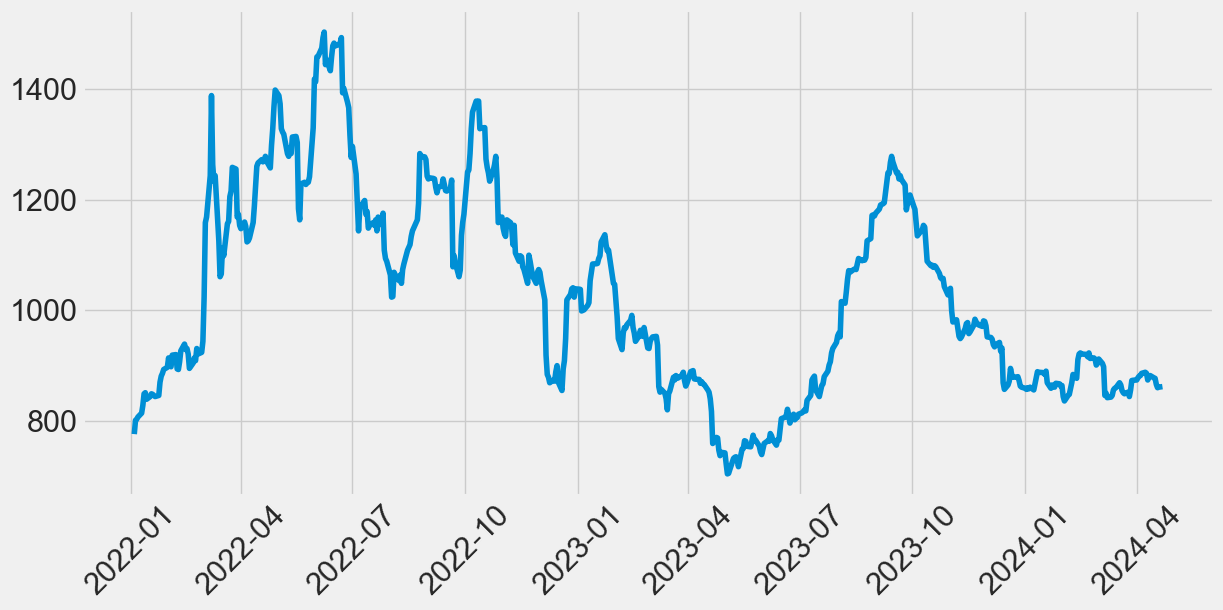

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.xticks(rotation=45)
plt.plot(ts);

# Train, test data splitting

In [4]:
last_date = ts.index.max()

test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape

((590, 1), (10, 1))

# Feature Engineering

## Time dummy

In [5]:
train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

## Lag features

In [6]:
def add_business_day_lags(df: pd.DataFrame, col_name: str, lag_days_list: list) -> pd.DataFrame:
    for days in lag_days_list:
        df[f'{col_name}_lag{days}'] = df[col_name].shift(days)
    df = df.fillna(method='bfill').fillna(method='ffill')
    return df

lag_days_list = [10, 20, 60, 120]

train_val = add_business_day_lags(train_val, 'Marine Gasoil 9_Price', lag_days_list)
test = add_business_day_lags(test, 'Marine Gasoil 9_Price', lag_days_list)

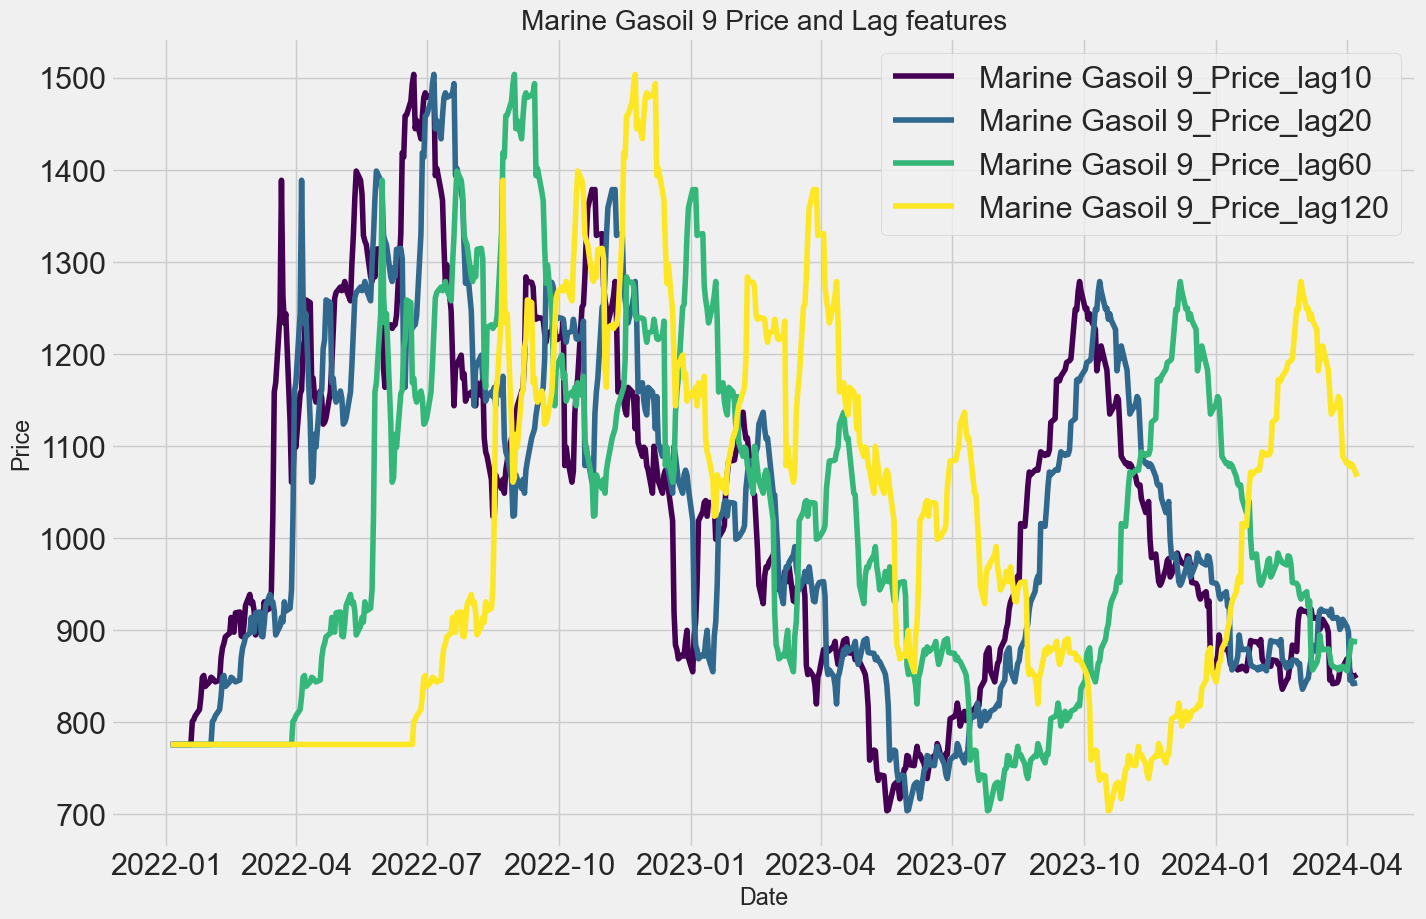

In [7]:
columns_to_plot = [
    'Marine Gasoil 9_Price_lag10',
    'Marine Gasoil 9_Price_lag20',
    'Marine Gasoil 9_Price_lag60',
    'Marine Gasoil 9_Price_lag120'
    ]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Lag features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Trend, Seasonality

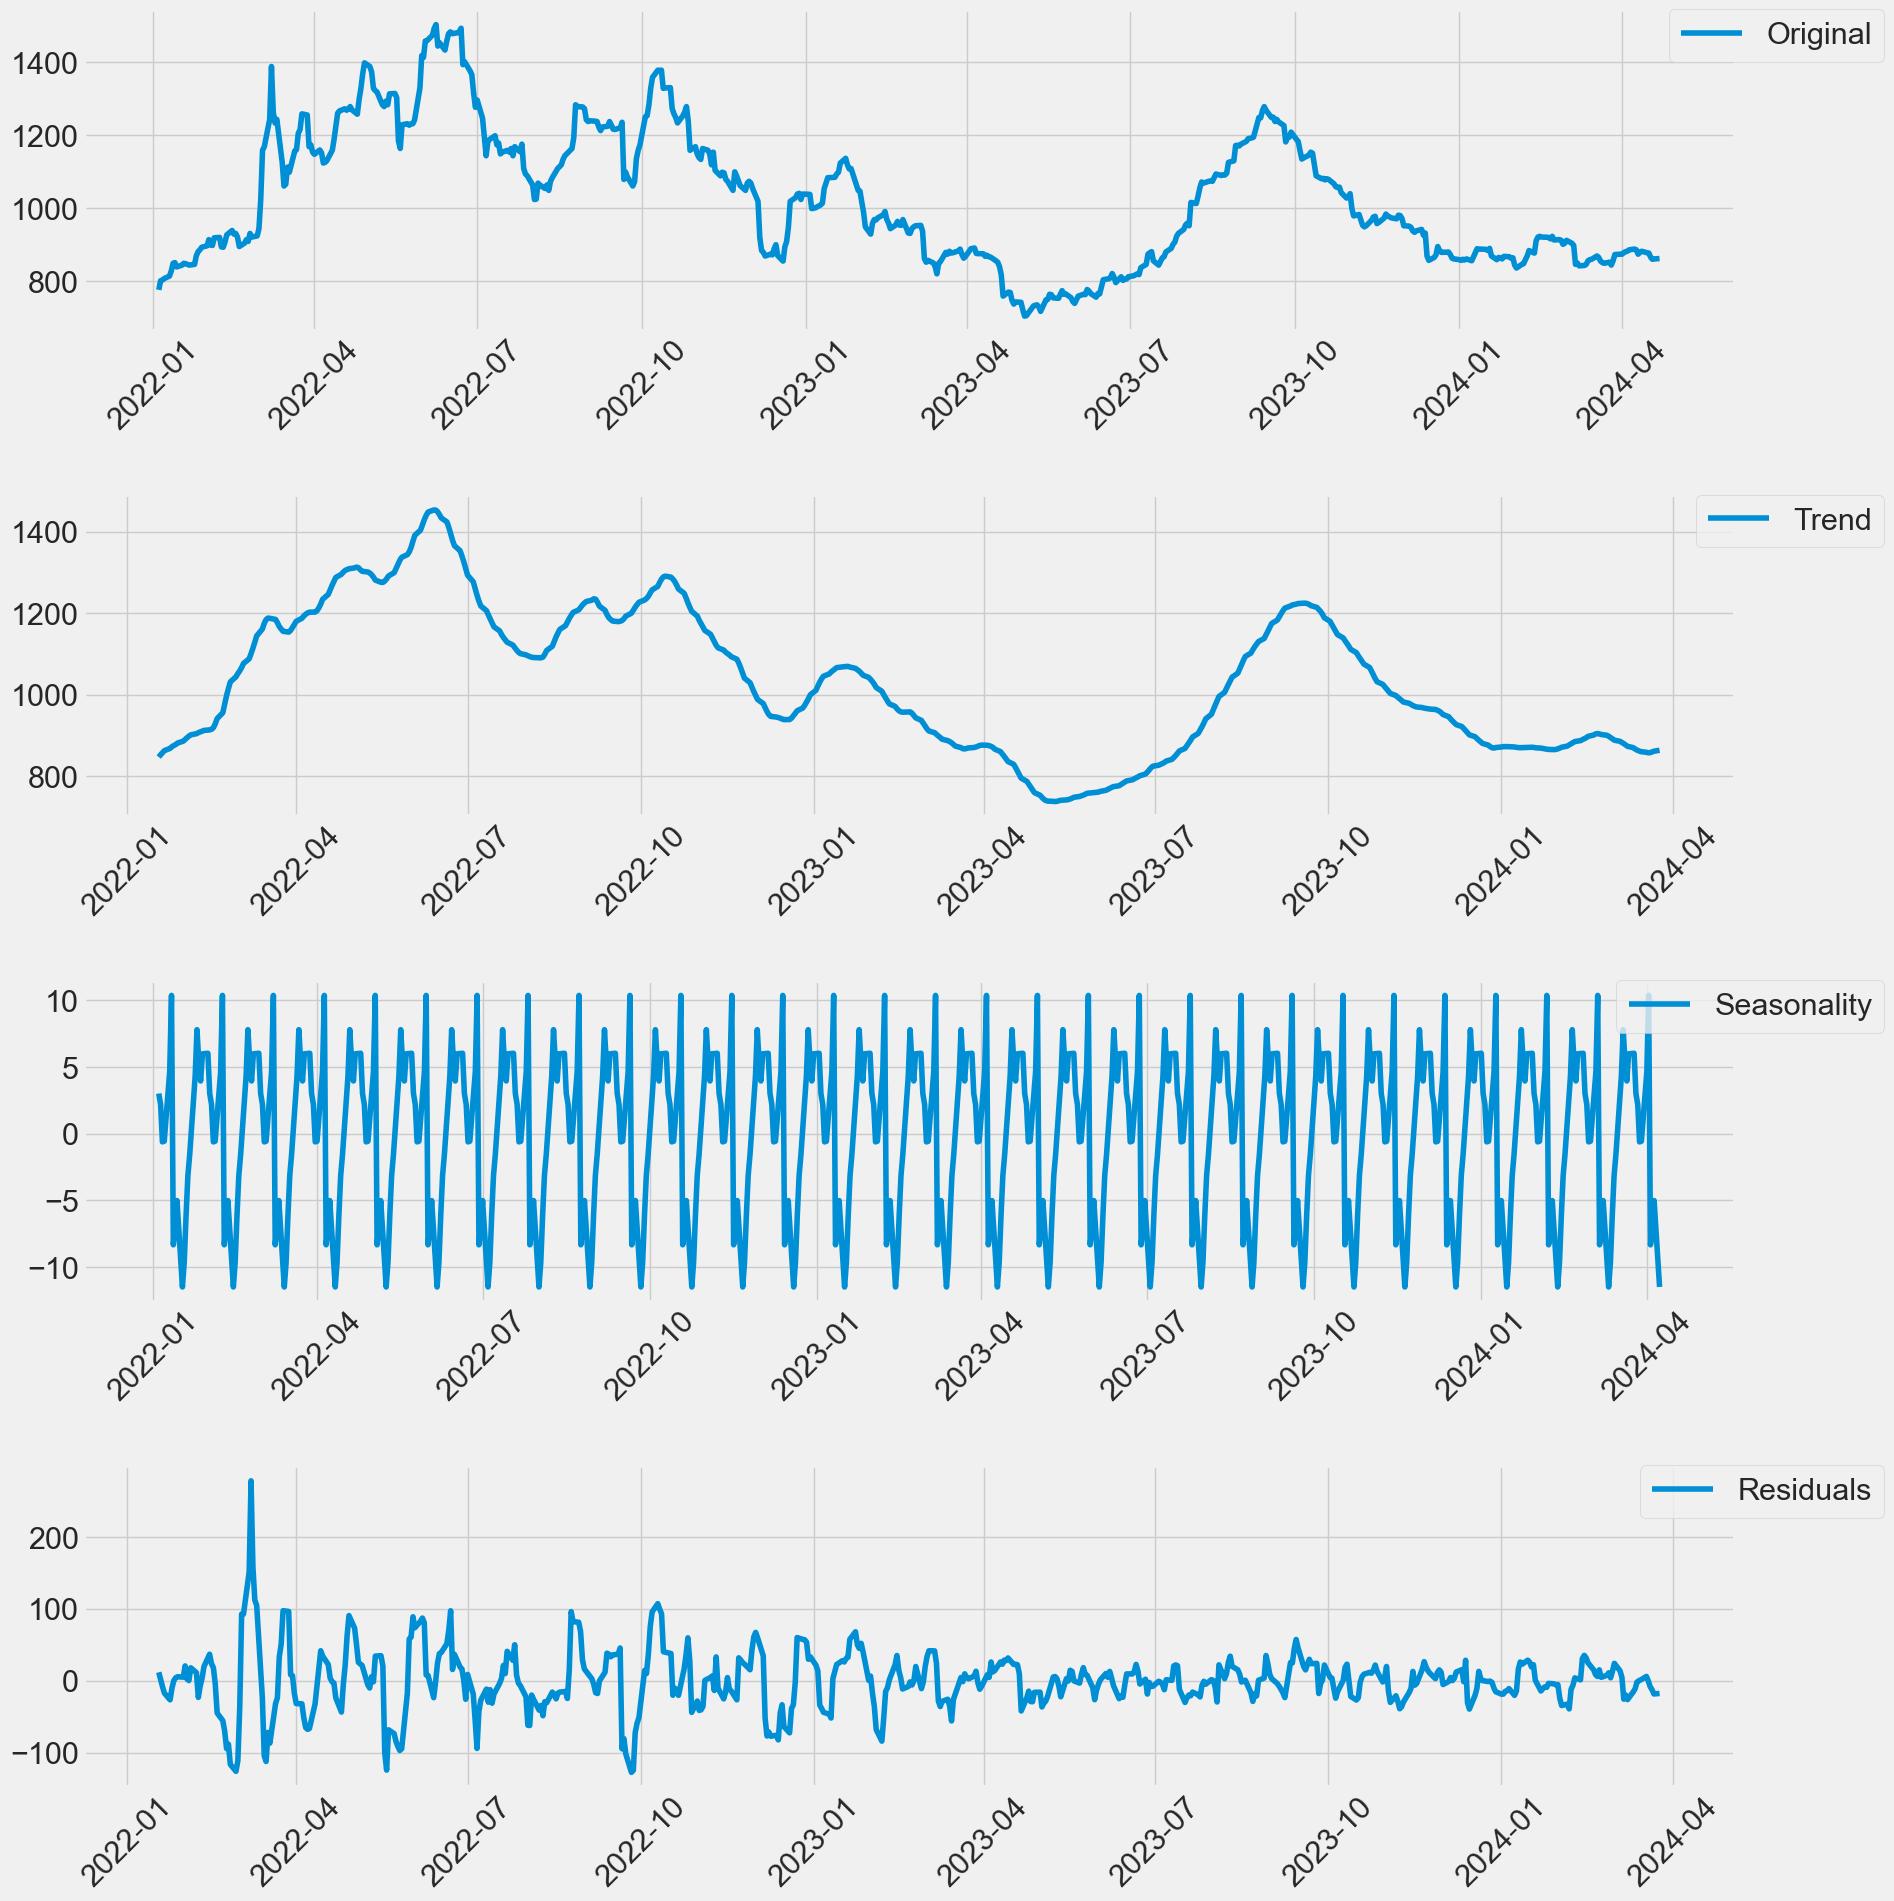

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_val['Marine Gasoil 9_Price'], period=20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

plt.rcParams["figure.figsize"] = (20, 20)
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout(pad=3.0)
plt.show()

In [9]:
train_val['trend'] = trend
train_val['seasonal'] = seasonal
train_val.head(30)

,Marine Gasoil 9_Price,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag10,Marine Gasoil 9_Price_lag20,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,trend,seasonal
Date,,,,,,,,,,,,,,
2022-01-04,775.5,2022,1,1,1,4,1,4,775.5,775.5,775.5,775.5,NaN,3.007006
2022-01-05,800.5,2022,1,1,2,5,1,5,775.5,775.5,775.5,775.5,NaN,2.181114
2022-01-06,802.5,2022,1,1,3,6,1,6,775.5,775.5,775.5,775.5,NaN,-0.623351
2022-01-07,806.5,2022,1,1,4,7,1,7,775.5,775.5,775.5,775.5,NaN,-0.577815
2022-01-10,813.5,2022,1,1,0,10,2,10,775.5,775.5,775.5,775.5,NaN,4.637364
2022-01-11,827.5,2022,1,1,1,11,2,11,775.5,775.5,775.5,775.5,NaN,10.371292
2022-01-12,848.5,2022,1,1,2,12,2,12,775.5,775.5,775.5,775.5,NaN,-8.351029
2022-01-13,850.5,2022,1,1,3,13,2,13,775.5,775.5,775.5,775.5,NaN,-7.010851
2022-01-14,838.5,2022,1,1,4,14,2,14,775.5,775.5,775.5,775.5,NaN,-5.029601


In [10]:
train_val.tail(20)

,Marine Gasoil 9_Price,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag10,Marine Gasoil 9_Price_lag20,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,trend,seasonal
Date,,,,,,,,,,,,,,
2024-03-12,845.5,2024,1,3,1,12,11,72,911.5,910.5,871.5,1181.5,866.5000,-9.654067
2024-03-13,855.5,2024,1,3,2,13,11,73,900.5,920.5,894.5,1193.5,863.6750,-6.150906
2024-03-14,858.5,2024,1,3,3,14,11,74,903.5,922.5,883.5,1194.5,861.7750,-3.155217
2024-03-15,859.5,2024,1,3,4,15,11,75,911.5,920.5,878.5,1208.5,860.0375,-1.583234
2024-03-18,868.5,2024,1,3,0,18,12,78,903.5,920.0,879.0,1188.5,858.3250,4.307714
2024-03-19,864.5,2024,1,3,1,19,12,79,897.5,919.5,879.5,1182.5,857.0750,7.799094
2024-03-20,854.5,2024,1,3,2,20,12,80,845.5,915.5,872.5,1157.5,857.4500,5.383577
2024-03-21,850.5,2024,1,3,3,21,12,81,849.5,922.5,862.5,1134.5,859.1250,3.949956
2024-03-22,848.5,2024,1,3,4,22,12,82,841.5,912.5,860.5,1137.5,861.0250,5.986163


### Experiment 1. Interative

In [11]:
def apply_sliding_window(train_feature, test_index, window_size):
    extended_feature = []
    windows = []
    
    for test_date in test_index:
        start_date = test_date - pd.Timedelta(days=window_size)
        window_values = train_feature.loc[start_date:test_date]
        if not window_values.empty:
            extended_feature.append(window_values.mean())
            windows.append(window_values)
        else:
            extended_feature.append(np.nan)
            windows.append(pd.Series())
    
    return extended_feature, windows

# Test 데이터의 날짜 리스트
test_dates = test.index

# Window size 설정
window_size = 14

# Test 데이터에 대해 Trend와 Seasonal feature 적용
trend_features, trend_windows = apply_sliding_window(train_val['trend'], test_dates, window_size)
seasonal_features, seasonal_windows = apply_sliding_window(train_val['seasonal'], test_dates, window_size)

test['trend'] = trend_features
test['seasonal'] = seasonal_features

In [12]:
test

,Marine Gasoil 9_Price,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag10,Marine Gasoil 9_Price_lag20,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,trend,seasonal
Date,,,,,,,,,,,,,,
2024-04-09,885.5,2024,2,4,1,9,15,100,NaN,NaN,NaN,NaN,NaN,-1.291148
2024-04-10,873.5,2024,2,4,2,10,15,101,NaN,NaN,NaN,NaN,NaN,-1.768721
2024-04-11,878.5,2024,2,4,3,11,15,102,NaN,NaN,NaN,NaN,NaN,-2.262450
2024-04-12,881.5,2024,2,4,4,12,15,103,NaN,NaN,NaN,NaN,NaN,-2.496608
2024-04-15,877.5,2024,2,4,0,15,16,106,NaN,NaN,NaN,NaN,NaN,-2.816406
2024-04-16,876.5,2024,2,4,1,16,16,107,NaN,NaN,NaN,NaN,NaN,-4.307160
2024-04-17,865.5,2024,2,4,2,17,16,108,NaN,NaN,NaN,NaN,NaN,-7.976773
2024-04-18,859.5,2024,2,4,3,18,16,109,NaN,NaN,NaN,NaN,NaN,-7.852021
2024-04-19,860.5,2024,2,4,4,19,16,110,NaN,NaN,NaN,NaN,NaN,-8.272607


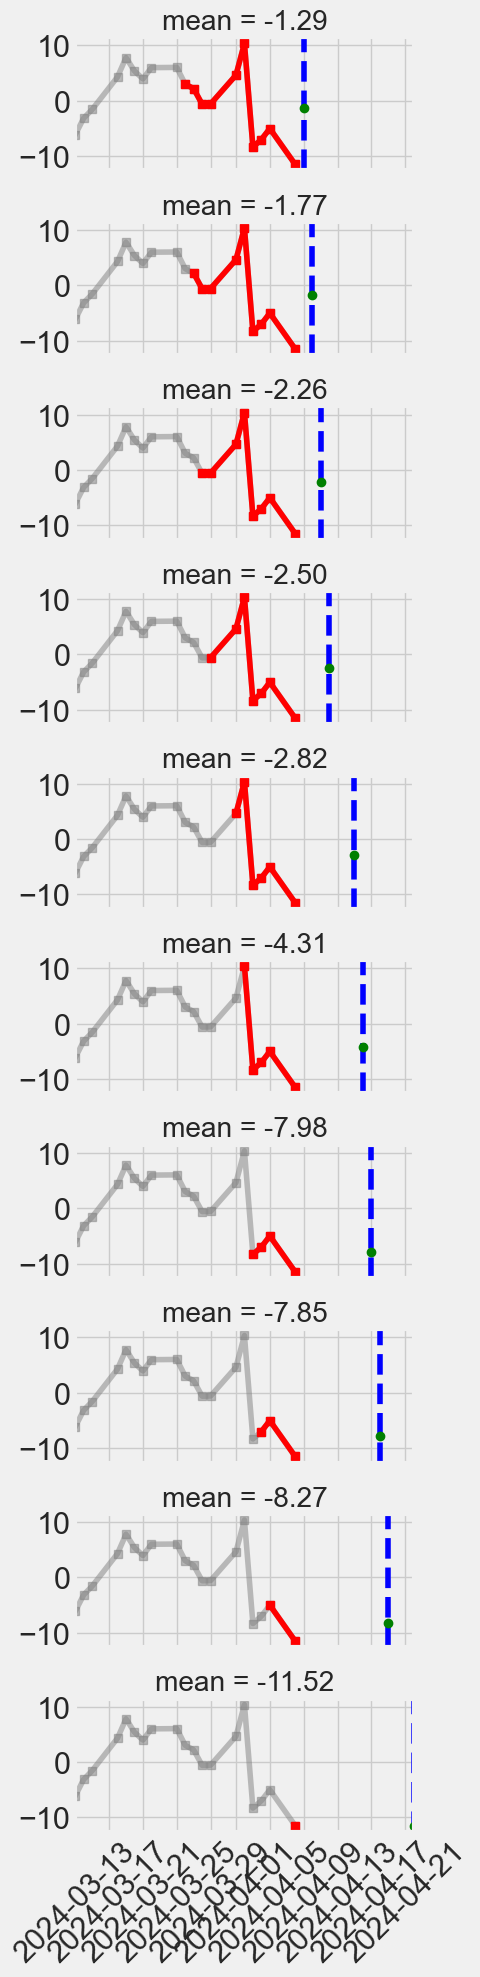

In [13]:
# 슬라이딩 윈도우 적용 및 결과 시각화
fig, axes = plt.subplots(len(test_dates), 1, figsize=(5, 20), sharex=True)

for i, (test_date, window) in enumerate(zip(test_dates, seasonal_windows)):
    axes[i].plot(train_val.index, train_val['seasonal'], 's-', color='grey', alpha=0.5, label='Seasonal Data')
    if not window.empty:
        axes[i].plot(window.index, window.values, 's-', color='red', label='Window Data')
        axes[i].axvline(test_date, color='blue', linestyle='--', label='Test Date')
        axes[i].set_xlim([test_date - pd.Timedelta(days=40), test_date])
        axes[i].set_title(f'mean = {window.mean():.2f}')
    
    # Test 데이터 시각화 추가
    if test_date in test.index:
        test_value = test.loc[test_date, 'seasonal']  # 'seasonal'은 예시입니다. 실제 데이터에 맞게 조정하세요.
        axes[i].plot(test_date, test_value, 'o', color='green', label='Test Data')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((570, 14), (20, 14), (10, 14))

In [15]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [16]:
# 모델 정의
cat_model = CatBoostRegressor(iterations=10000,
                              learning_rate=0.01,
                              depth=6,
                              l2_leaf_reg=1,
                              eval_metric='RMSE',
                              random_seed=42,
                              bagging_temperature=0.8,
                              od_type='Iter',
                              od_wait=50)

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']

tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    cat_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = cat_model.predict(X_train)
    y_val_pred = cat_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

0:	learn: 184.4310750	test: 198.4083169	best: 198.4083169 (0)	total: 149ms	remaining: 24m 52s
100:	learn: 88.6639386	test: 138.2007862	best: 138.2007862 (100)	total: 269ms	remaining: 26.4s
200:	learn: 51.7908129	test: 123.2651664	best: 123.2651664 (200)	total: 413ms	remaining: 20.2s
300:	learn: 35.5759202	test: 117.4122157	best: 117.4101574 (299)	total: 567ms	remaining: 18.3s
400:	learn: 26.4602987	test: 115.2625273	best: 115.2226226 (398)	total: 726ms	remaining: 17.4s
500:	learn: 20.0013992	test: 114.7526263	best: 114.5591339 (492)	total: 900ms	remaining: 17.1s
600:	learn: 15.4546438	test: 114.1186941	best: 113.9753828 (563)	total: 1.08s	remaining: 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 113.9753828
bestIteration = 563

Shrink model to first 564 iterations.
0:	learn: 176.7485024	test: 154.2722243	best: 154.2722243 (0)	total: 2.73ms	remaining: 27.3s
100:	learn: 88.5813987	test: 129.3534991	best: 129.3534991 (100)	total: 255ms	remaining: 25s
200:	learn: 54.

In [18]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [89.41480626952246, 89.60807459870553, 178.56266263108142, 39.95478168258484, 31.531204809647303]
Average MAE across folds: 85.81
RMSE for each fold: [113.97538279945599, 115.90601760559163, 192.34346875366498, 49.870993521467454, 41.35459495304513]
Average RMSE across folds: 102.69
MAPE for each fold: [7.130055619065313, 8.932931616094478, 22.69270772099802, 3.6313719252846406, 3.6092136427671924]
Average MAPE across folds: 9.20


In [19]:
# 최종 모델 학습
cat_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

0:	learn: 186.6401268	test: 170.4026658	best: 170.4026658 (0)	total: 6.63ms	remaining: 1m 6s
100:	learn: 88.9590468	test: 75.7950903	best: 75.7950903 (100)	total: 591ms	remaining: 58s
200:	learn: 52.8720288	test: 47.1146169	best: 47.1146169 (200)	total: 1.17s	remaining: 57.2s
300:	learn: 39.1025811	test: 41.7348833	best: 41.7041748 (299)	total: 1.74s	remaining: 56.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 41.35459493
bestIteration = 340

Shrink model to first 341 iterations.


In [20]:
pred_val = cat_model.predict(X_val)
pred_test = cat_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_cat_val_ex1'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_cat_ex1'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

,Marine Gasoil 9_Price,prediction_cat_val_ex1,prediction_cat_ex1
Date,,,
2022-01-04,775.5,NaN,NaN
2022-01-05,800.5,NaN,NaN
2022-01-06,802.5,NaN,NaN
2022-01-07,806.5,NaN,NaN
2022-01-10,813.5,NaN,NaN
...,...,...,...
2024-04-16,876.5,NaN,809.574003
2024-04-17,865.5,NaN,810.577429
2024-04-18,859.5,NaN,809.565758


#### Prediction

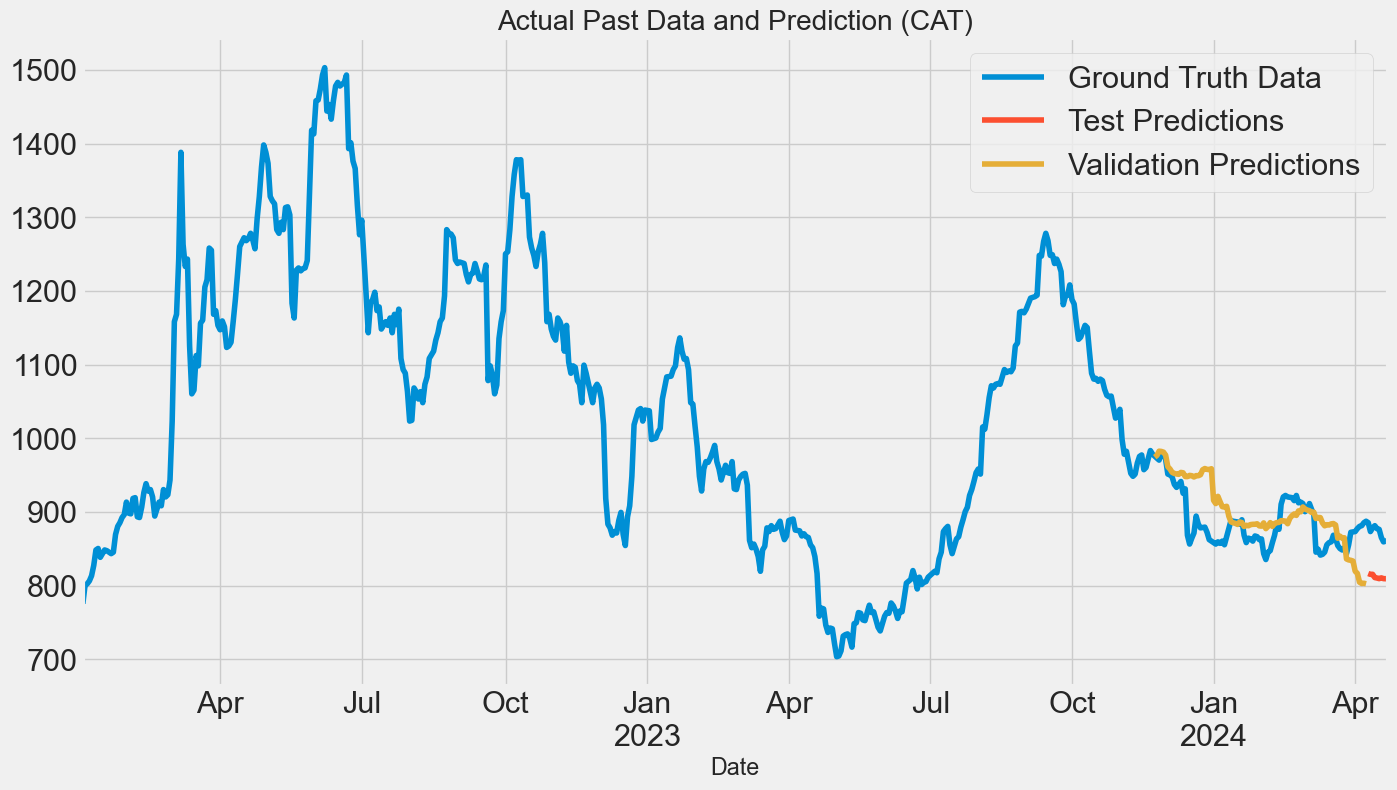

In [21]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_cat_ex1'].plot(ax=ax, style='-')
ts['prediction_cat_val_ex1'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (CAT)')
plt.show();

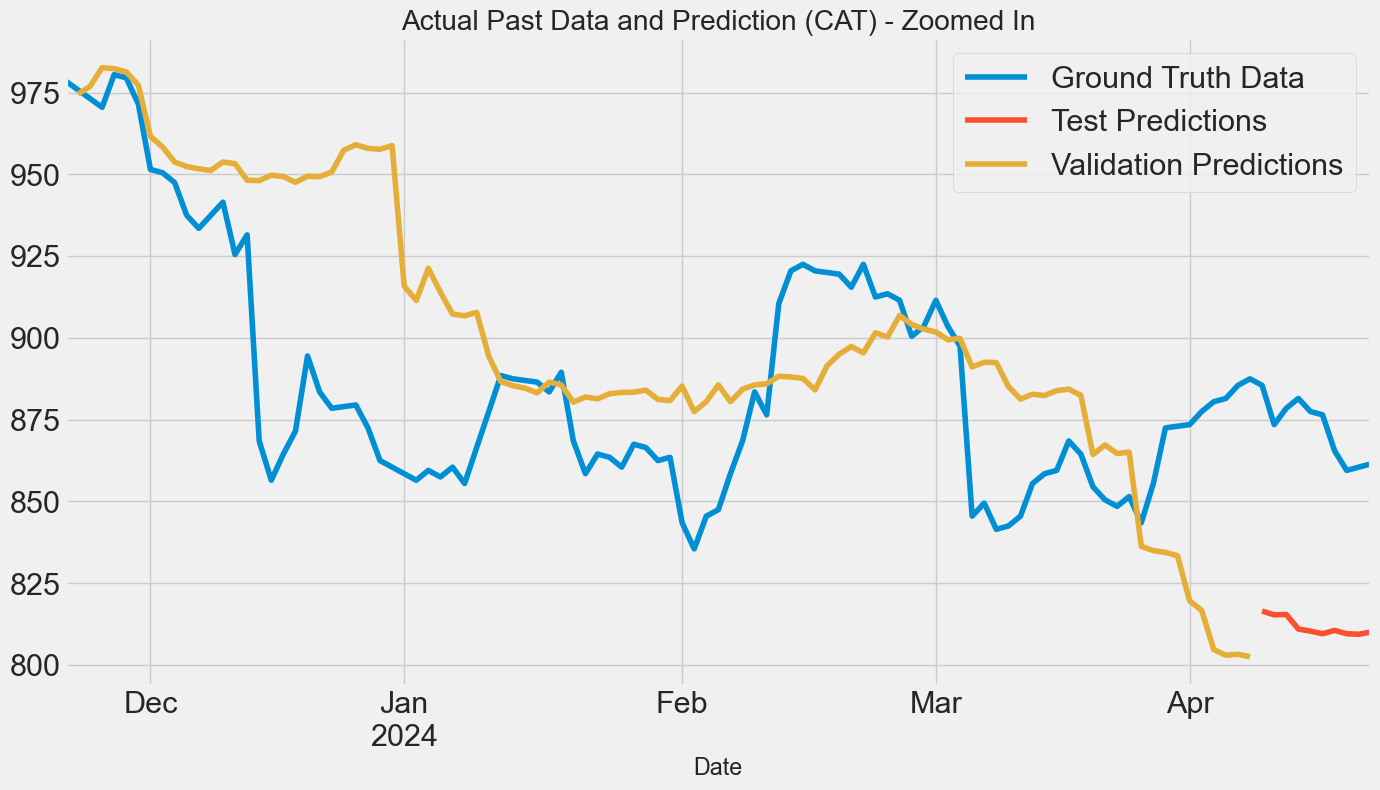

In [22]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-11-22'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_cat_ex1'].plot(ax=ax, style='-')
ts_zoomed['prediction_cat_val_ex1'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (CAT) - Zoomed In')
plt.show()

#### MAE, RMSE, MAPE

In [23]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_cat_val_ex1', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_cat_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_val_ex1'])
score_rmse_cat_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_val_ex1']))
score_mape_cat_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_val_ex1'])

# 결과 출력
print(f'MAE Score on Validation set (CAT): {score_mae_cat_val:0.2f}')
print(f'RMSE Score on Validation set (CAT): {score_rmse_cat_val:0.2f}')
print(f'MAPE Score on Validation set (CAT): {score_mape_cat_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (CAT): 31.53
RMSE Score on Validation set (CAT): 41.35
MAPE Score on Validation set (CAT): 3.61%


In [24]:
ts_clean = ts.dropna(subset=['prediction_cat_ex1', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_cat = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_ex1'])
score_rmse_cat = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_ex1']))
score_mape_cat = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_ex1'])

# 결과 출력
print(f'MAE Score on Test set (CAT): {score_mae_cat:0.2f}')
print(f'RMSE Score on Test set (CAT): {score_rmse_cat:0.2f}')
print(f'MAPE Score on Test set (CAT): {score_mape_cat:.2%}')  # 백분율 형식으로 출력

MAE Score on Test set (CAT): 60.21
RMSE Score on Test set (CAT): 60.69
MAPE Score on Test set (CAT): 6.90%


#### Shap

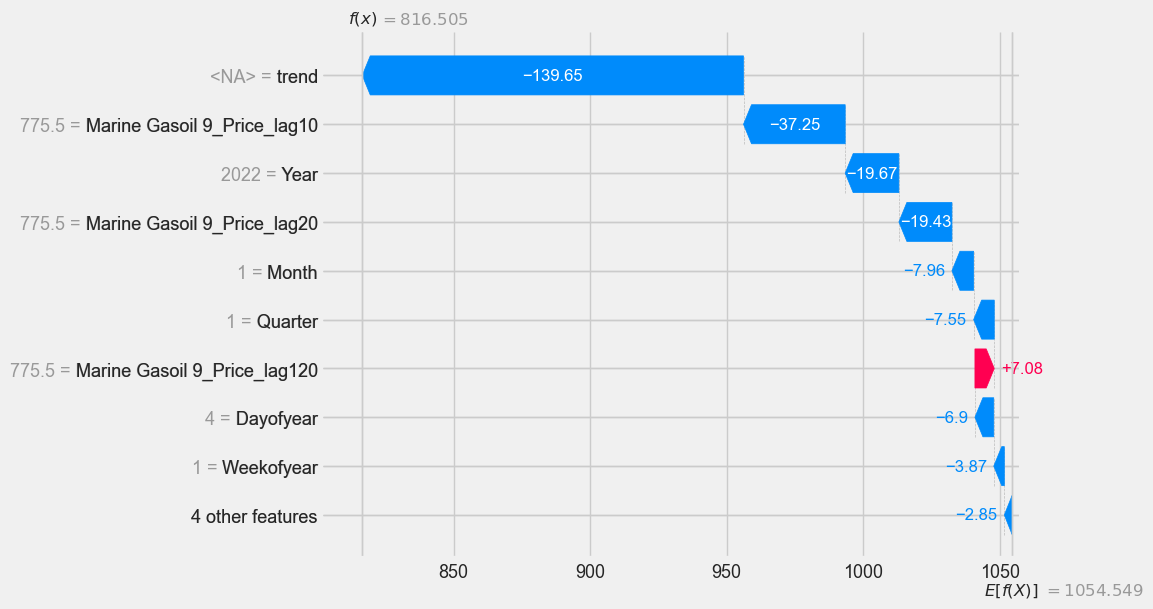

In [25]:
import shap

cat_explainer = shap.Explainer(cat_model)
shap_values_cat = cat_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_cat[0],
                                     base_values=cat_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

#### Hyperparameter tuning

In [ ]:
cat_model = CatBoostRegressor(iterations=10000,
                              learning_rate=0.01,
                              depth=6,
                              l2_leaf_reg=1,
                              eval_metric='RMSE',
                              random_seed=42,
                              bagging_temperature=0.8,
                              od_type='Iter',
                              od_wait=50)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=100
)

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']

# GridSearch 실행
grid_search.fit(X_train_val, y_train_val)

In [ ]:
# 결과 출력
print("Best parameters:", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

In [ ]:
# 모델 수정

cat_model = CatBoostRegressor(iterations=10000,
                              learning_rate=0.01,
                              depth=4,
                              l2_leaf_reg=5,
                              eval_metric='RMSE',
                              random_seed=42,
                              bagging_temperature=0.8,
                              od_type='Iter',
                              od_wait=50)

In [ ]:
# crossvalidation 코드부터 시작

### ✨Experiment 2. Recurrent

In [26]:
ts = pd.read_csv('05_MG9_ts.csv', index_col='Date')
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('B')
ts = ts.interpolate(method='linear')

last_date = ts.index.max()

test_start_date = last_date - pd.Timedelta(days=14)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)

train_val = ts.loc[ts.index <= test_start_date]
test = ts.loc[ts.index > test_start_date]

train_val.shape, test.shape

train_val['Year'] = train_val.index.year
train_val['Quarter'] = train_val.index.quarter
train_val['Month'] = train_val.index.month
train_val['Dayofweek'] = train_val.index.dayofweek
train_val['Dayofmonth'] = train_val.index.day
train_val['Weekofyear'] = train_val.index.isocalendar().week
train_val['Dayofyear'] = train_val.index.dayofyear

test['Year'] = test.index.year
test['Quarter'] = test.index.quarter
test['Month'] = test.index.month
test['Dayofweek'] = test.index.dayofweek
test['Dayofmonth'] = test.index.day
test['Weekofyear'] = test.index.isocalendar().week
test['Dayofyear'] = test.index.dayofyear

lag_days_list = [10, 20, 60, 120]

train_val = add_business_day_lags(train_val, 'Marine Gasoil 9_Price', lag_days_list)
test = add_business_day_lags(test, 'Marine Gasoil 9_Price', lag_days_list)

decomposition = seasonal_decompose(train_val['Marine Gasoil 9_Price'], period=20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

train_val['trend'] = trend
train_val['seasonal'] = seasonal

In [27]:
def apply_sliding_window_recursive(train_features, test_index, window_size, current_index=0, full_data=None, extended_features=None, windows=None):
    if full_data is None:
        full_data = train_features.copy()
    if extended_features is None:
        extended_features = {col: [] for col in train_features.columns}
    if windows is None:
        windows = {col: [] for col in train_features.columns}

    if current_index >= len(test_index):
        return extended_features, windows

    test_date = test_index[current_index]
    start_date = test_date - pd.Timedelta(days=window_size)
    
    for col in train_features.columns:
        window_values = full_data[col].loc[start_date:test_date]
        
        if not window_values.empty:
            mean_value = window_values.mean()
            extended_features[col].append(mean_value)
            windows[col].append(window_values)
            full_data.at[test_date, col] = mean_value
        else:
            extended_features[col].append(np.nan)
            windows[col].append(pd.Series(dtype=float))

    return apply_sliding_window_recursive(train_features, test_index, window_size, current_index + 1, full_data, extended_features, windows)

# Window size 설정
window_size = 14

# Test 데이터에 대해 Trend와 Seasonal feature 적용
extended_features, windows = apply_sliding_window_recursive(train_val[['trend', 'seasonal']], test_dates, window_size)

test['trend'] = extended_features['trend']
test['seasonal'] = extended_features['seasonal']

In [28]:
test

,Marine Gasoil 9_Price,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag10,Marine Gasoil 9_Price_lag20,Marine Gasoil 9_Price_lag60,Marine Gasoil 9_Price_lag120,trend,seasonal
Date,,,,,,,,,,,,,,
2024-04-09,885.5,2024,2,4,1,9,15,100,NaN,NaN,NaN,NaN,NaN,-1.291148
2024-04-10,873.5,2024,2,4,2,10,15,101,NaN,NaN,NaN,NaN,NaN,-1.720964
2024-04-11,878.5,2024,2,4,3,11,15,102,NaN,NaN,NaN,NaN,NaN,-2.111172
2024-04-12,881.5,2024,2,4,4,12,15,103,NaN,NaN,NaN,NaN,NaN,-2.259954
2024-04-15,877.5,2024,2,4,0,15,16,106,NaN,NaN,NaN,NaN,NaN,-2.428168
2024-04-16,876.5,2024,2,4,1,16,16,107,NaN,NaN,NaN,NaN,NaN,-3.134721
2024-04-17,865.5,2024,2,4,2,17,16,108,NaN,NaN,NaN,NaN,NaN,-4.485322
2024-04-18,859.5,2024,2,4,3,18,16,109,NaN,NaN,NaN,NaN,NaN,-4.098751
2024-04-19,860.5,2024,2,4,4,19,16,110,NaN,NaN,NaN,NaN,NaN,-3.807541


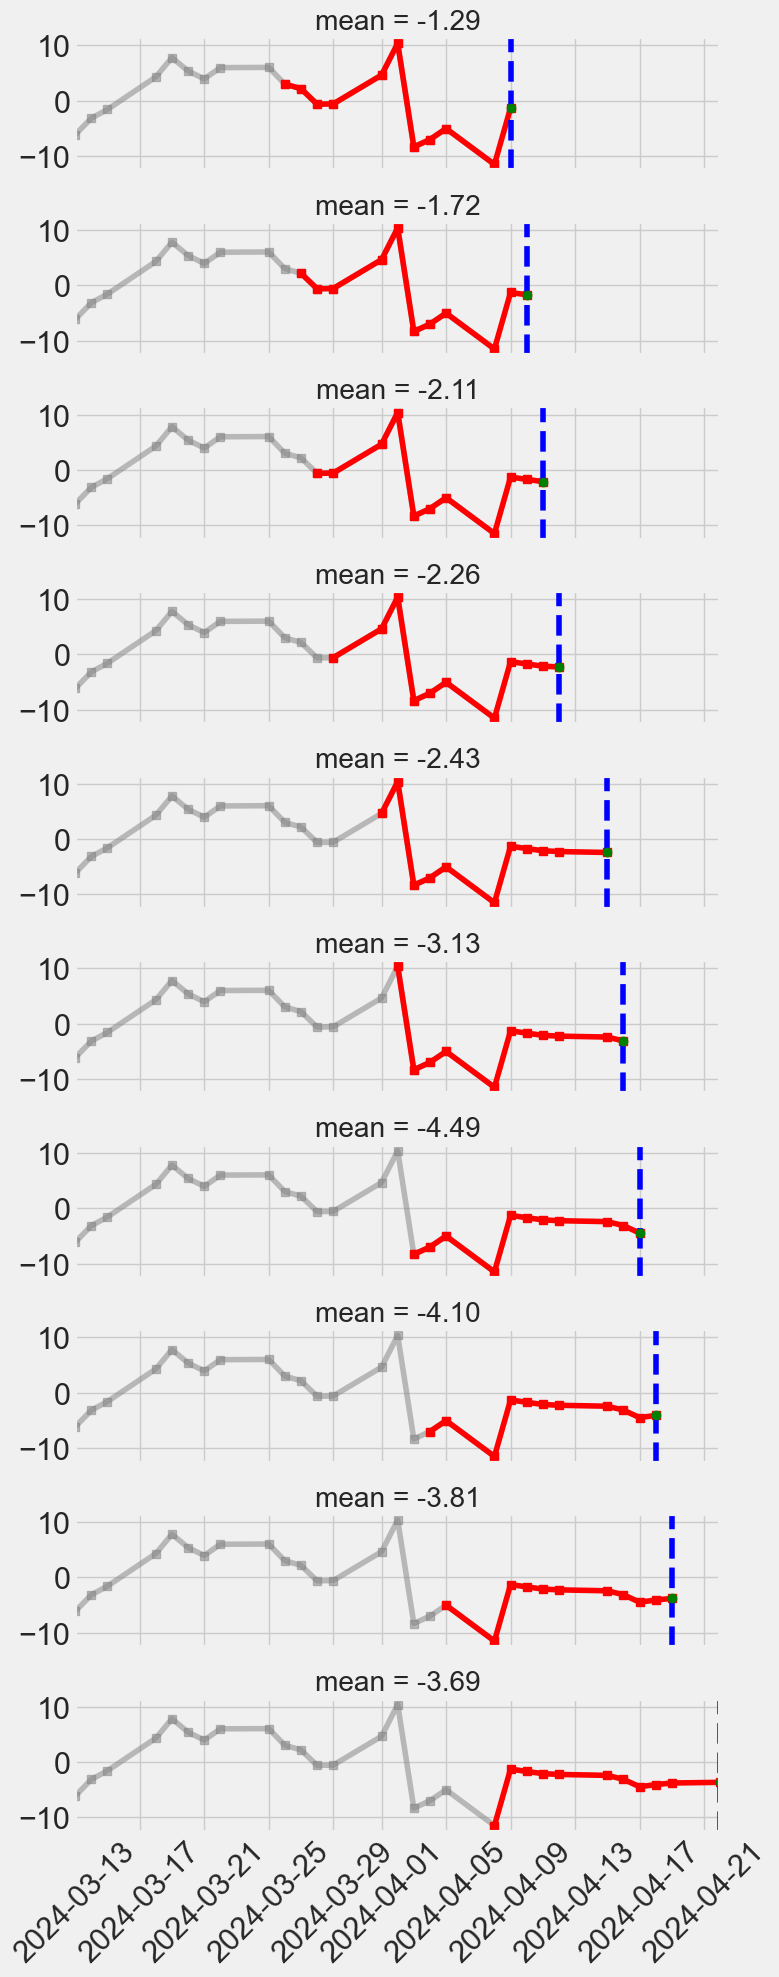

In [29]:
# 슬라이딩 윈도우 적용 및 결과 시각화
fig, axes = plt.subplots(len(test_dates), 1, figsize=(8, 20), sharex=True)

for i, test_date in enumerate(test_dates):
    window = windows['seasonal'][i]
    axes[i].plot(train_val.index, train_val['seasonal'], 's-', color='grey', alpha=0.5, label='Seasonal Data')
    if not window.empty:
        axes[i].plot(window.index, window.values, 's-', color='red', label='Window Data')
        axes[i].axvline(test_date, color='blue', linestyle='--', label='Test Date')
        axes[i].set_xlim([test_date - pd.Timedelta(days=40), test_date])
        axes[i].set_title(f'mean = {window.mean():.2f}')
    
    # Test 데이터 시각화 추가
    if test_date in test.index:
        test_value = test.loc[test_date, 'seasonal']
        axes[i].plot(test_date, test_value, 'o', color='green', label='Test Data')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((570, 14), (20, 14), (10, 14))

In [31]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [32]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']

tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    cat_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = cat_model.predict(X_train)
    y_val_pred = cat_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

0:	learn: 184.4310750	test: 198.4083169	best: 198.4083169 (0)	total: 1.78ms	remaining: 17.8s
100:	learn: 88.6639386	test: 138.2007862	best: 138.2007862 (100)	total: 135ms	remaining: 13.2s
200:	learn: 51.7908129	test: 123.2651664	best: 123.2651664 (200)	total: 293ms	remaining: 14.3s
300:	learn: 35.5759202	test: 117.4122157	best: 117.4101574 (299)	total: 477ms	remaining: 15.4s
400:	learn: 26.4602987	test: 115.2625273	best: 115.2226226 (398)	total: 659ms	remaining: 15.8s
500:	learn: 20.0013992	test: 114.7526263	best: 114.5591339 (492)	total: 835ms	remaining: 15.8s
600:	learn: 15.4546438	test: 114.1186941	best: 113.9753828 (563)	total: 1.02s	remaining: 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 113.9753828
bestIteration = 563

Shrink model to first 564 iterations.
0:	learn: 176.7485024	test: 154.2722243	best: 154.2722243 (0)	total: 2.76ms	remaining: 27.6s
100:	learn: 88.5813987	test: 129.3534991	best: 129.3534991 (100)	total: 237ms	remaining: 23.2s
200:	learn: 54

In [33]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [89.41480626952246, 89.60807459870553, 178.56266263108142, 39.95478168258484, 31.531204809647303]
Average MAE across folds: 85.81
RMSE for each fold: [113.97538279945599, 115.90601760559163, 192.34346875366498, 49.870993521467454, 41.35459495304513]
Average RMSE across folds: 102.69
MAPE for each fold: [7.130055619065313, 8.932931616094478, 22.69270772099802, 3.6313719252846406, 3.6092136427671924]
Average MAPE across folds: 9.20


In [34]:
# 최종 모델 학습
cat_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

0:	learn: 186.6401268	test: 170.4026658	best: 170.4026658 (0)	total: 4.67ms	remaining: 46.7s
100:	learn: 88.9590468	test: 75.7950903	best: 75.7950903 (100)	total: 449ms	remaining: 44.1s
200:	learn: 52.8720288	test: 47.1146169	best: 47.1146169 (200)	total: 830ms	remaining: 40.5s
300:	learn: 39.1025811	test: 41.7348833	best: 41.7041748 (299)	total: 1.2s	remaining: 38.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 41.35459493
bestIteration = 340

Shrink model to first 341 iterations.


In [35]:
pred_val = cat_model.predict(X_val)
pred_test = cat_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_cat_val_ex2'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_cat_ex2'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

,Marine Gasoil 9_Price,prediction_cat_val_ex2,prediction_cat_ex2
Date,,,
2022-01-04,775.5,NaN,NaN
2022-01-05,800.5,NaN,NaN
2022-01-06,802.5,NaN,NaN
2022-01-07,806.5,NaN,NaN
2022-01-10,813.5,NaN,NaN
...,...,...,...
2024-04-16,876.5,NaN,810.190830
2024-04-17,865.5,NaN,810.033184
2024-04-18,859.5,NaN,808.978021


#### Prediction

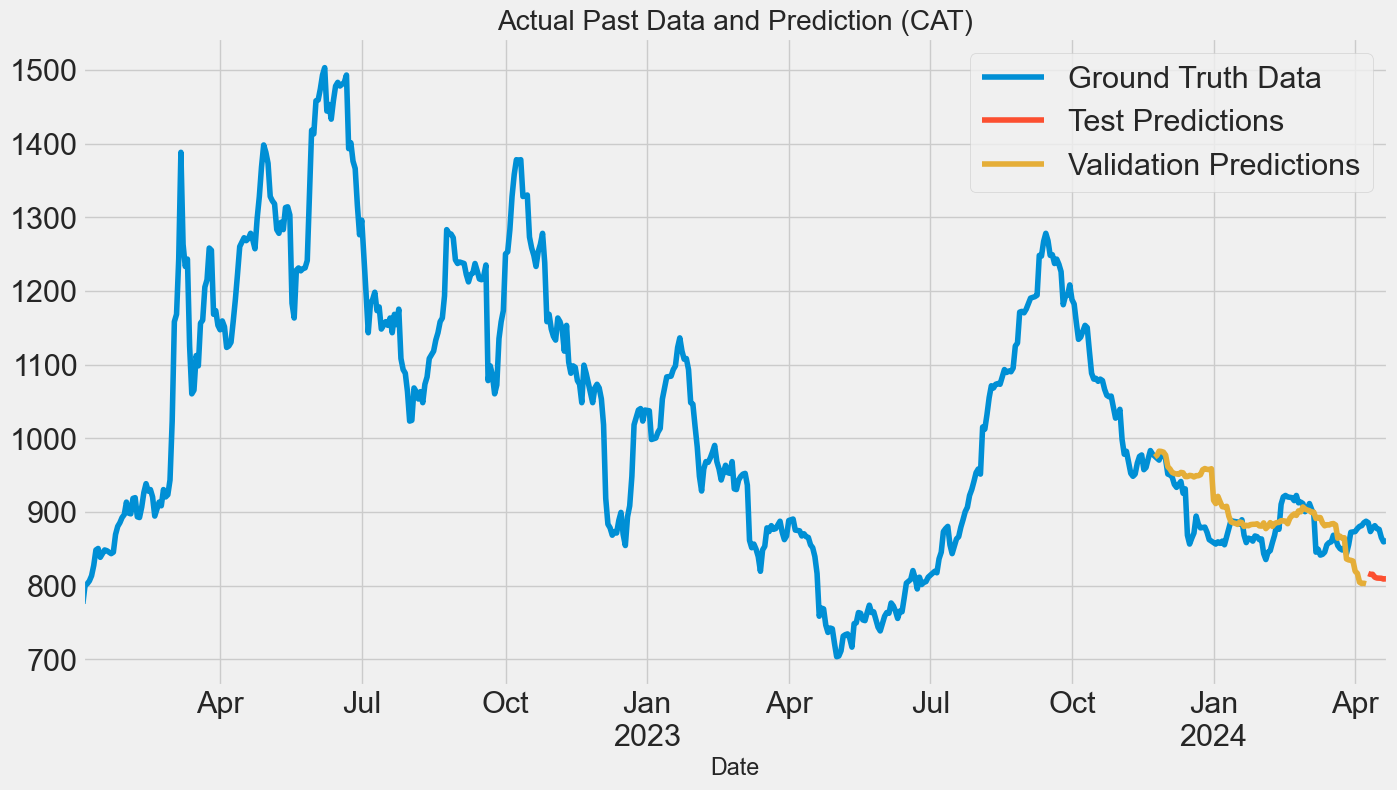

In [36]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_cat_ex2'].plot(ax=ax, style='-')
ts['prediction_cat_val_ex2'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (CAT)')
plt.show();

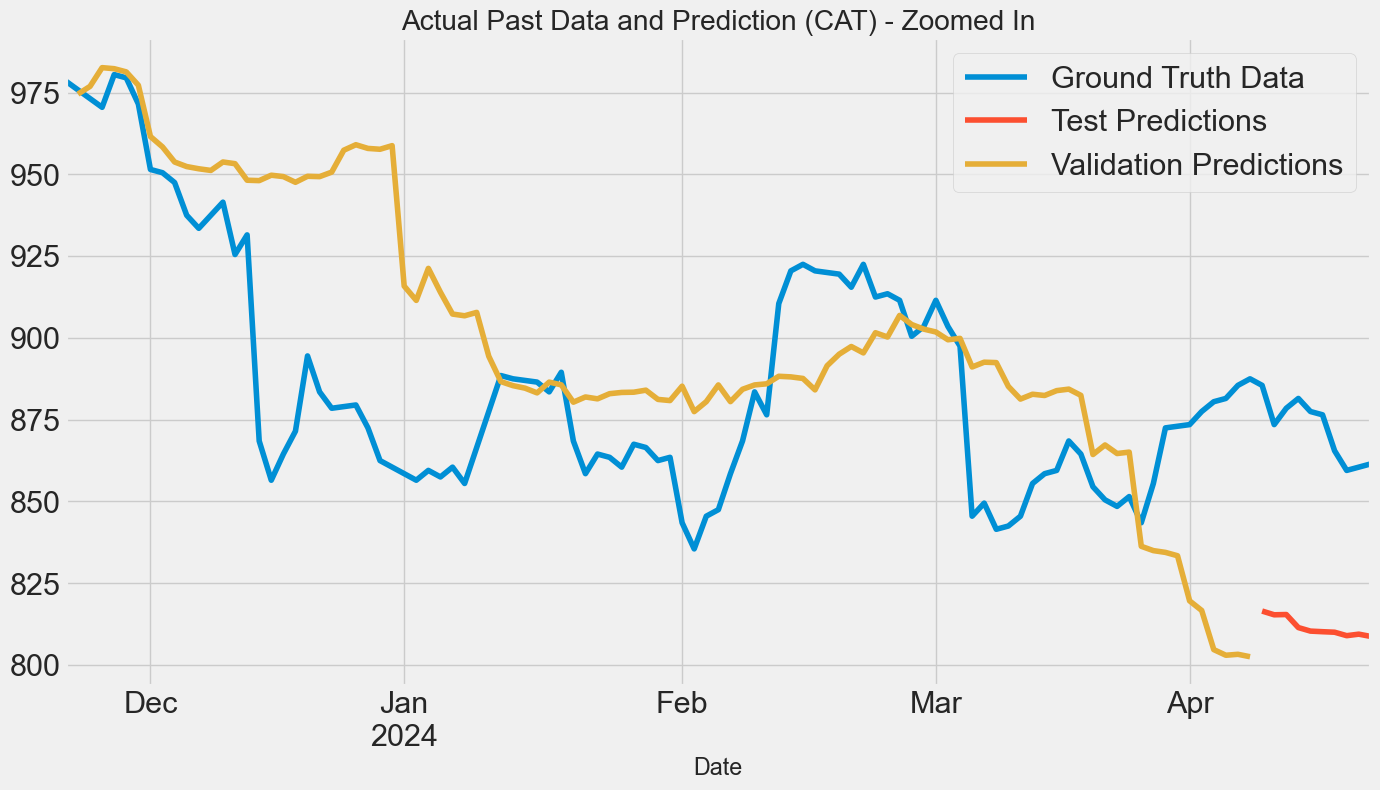

In [37]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-11-22'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_cat_ex2'].plot(ax=ax, style='-')
ts_zoomed['prediction_cat_val_ex2'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (CAT) - Zoomed In')
plt.show()

#### MAE, RMSE, MAPE

In [38]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_cat_val_ex2', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_cat_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_val_ex2'])
score_rmse_cat_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_val_ex2']))
score_mape_cat_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_val_ex2'])

# 결과 출력
print(f'MAE Score on Validation set (CAT): {score_mae_cat_val:0.2f}')
print(f'RMSE Score on Validation set (CAT): {score_rmse_cat_val:0.2f}')
print(f'MAPE Score on Validation set (CAT): {score_mape_cat_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (CAT): 31.53
RMSE Score on Validation set (CAT): 41.35
MAPE Score on Validation set (CAT): 3.61%


In [39]:
ts_clean = ts.dropna(subset=['prediction_cat_ex2', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_cat = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_ex2'])
score_rmse_cat = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_ex2']))
score_mape_cat = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_ex2'])

# 결과 출력
print(f'MAE Score on Test set (CAT): {score_mae_cat:0.2f}')
print(f'RMSE Score on Test set (CAT): {score_rmse_cat:0.2f}')
print(f'MAPE Score on Test set (CAT): {score_mape_cat:.2%}')  # 백분율 형식으로 출력

MAE Score on Test set (CAT): 60.35
RMSE Score on Test set (CAT): 60.78
MAPE Score on Test set (CAT): 6.91%


#### Shap

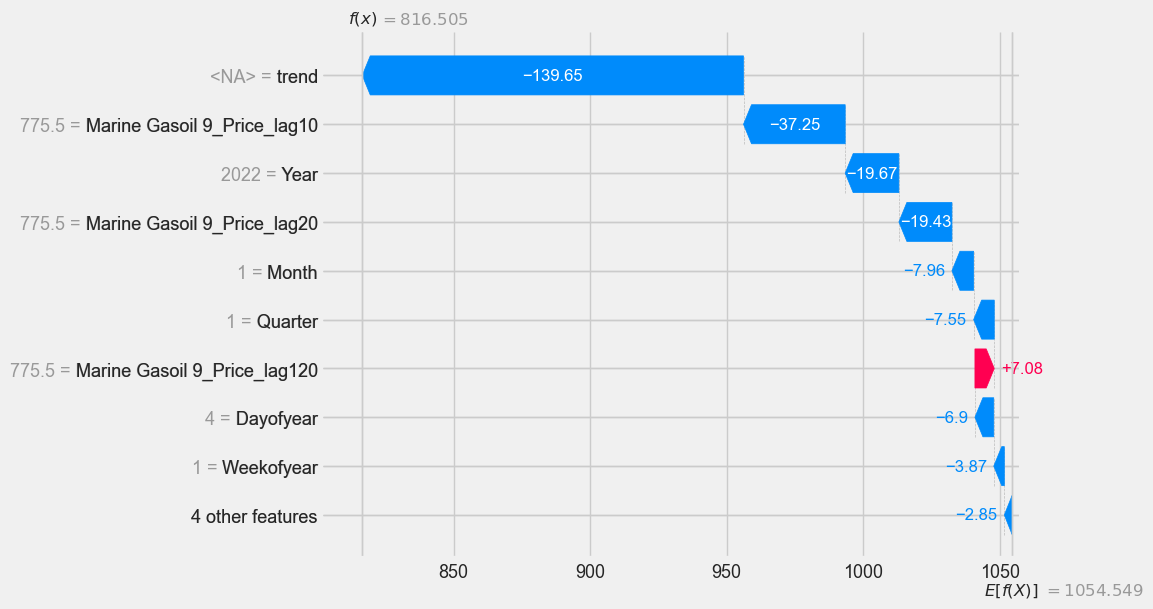

In [40]:
cat_explainer = shap.Explainer(cat_model)
shap_values_cat = cat_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_cat[0],
                                     base_values=cat_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

### Experiment 3.Cyclic

In [41]:
def apply_sliding_window(train_feature, test_index, window_size):
    extended_feature = []
    windows = []
    
    for test_date in test_index:
        start_date = test_date - pd.Timedelta(days=window_size)
        window_values = train_feature.loc[start_date:test_date]
        if not window_values.empty:
            extended_feature.append(window_values.mean())
            windows.append(window_values)
        else:
            extended_feature.append(np.nan)
            windows.append(pd.Series())
    
    return extended_feature, windows

# Test 데이터의 날짜 리스트
test_dates = test.index

# Window size 설정
window_size = 14

# Test 데이터에 대해 Trend와 Seasonal feature 적용
trend_features, trend_windows = apply_sliding_window(train_val['trend'], test_dates, window_size)
seasonal_features, seasonal_windows = apply_sliding_window(train_val['seasonal'], test_dates, window_size)

test['trend'] = trend_features
test['seasonal'] = seasonal_features

In [42]:
# 주기적 반복 함수 정의
def apply_periodic_features(train_df, test_index, period):
    extended_features = {col: [] for col in train_df.columns}
    train_length = len(train_df)
    start_point = train_length - period
    for i, test_date in enumerate(test_index):
        index_in_period = (start_point + i) % train_length
        for col in train_df.columns:
            extended_features[col].append(train_df.iloc[index_in_period][col])
    return pd.DataFrame(extended_features, index=test_index)

# 주기 설정
period = 20

# Test 데이터에 대해 Trend와 Seasonal feature 적용
test_features = apply_periodic_features(train_val, test_dates, period)
test['trend'] = test_features['trend']
test['seasonal'] = test_features['seasonal']

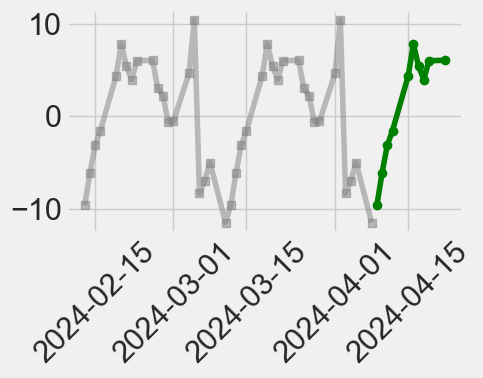

In [43]:
# 최근 40일 데이터 선택
recent_40_days = train_val.index[-40:]

# 결과 시각화
fig, ax = plt.subplots(figsize=(5, 4))

# 전체 train_val 데이터 시각화 (최근 40일 기준)
ax.plot(train_val.loc[recent_40_days].index, train_val.loc[recent_40_days]['seasonal'], 's-', color='grey', alpha=0.5, label='Seasonal Data')

# 테스트 데이터의 선 시각화
ax.plot(test.index, test['seasonal'], 'o-', color='green', label='Test Data')

# 중복 범례 제거
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

train.shape, validation.shape, test.shape

((570, 14), (20, 14), (10, 14))

In [45]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [46]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_val = train_val.drop(columns=['Marine Gasoil 9_Price'])
y_train_val = train_val['Marine Gasoil 9_Price']
X_test = test.drop(columns=['Marine Gasoil 9_Price'])
y_test = test['Marine Gasoil 9_Price']

tss = TimeSeriesSplit(n_splits = 5)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    cat_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = cat_model.predict(X_train)
    y_val_pred = cat_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

0:	learn: 184.4310750	test: 198.4083169	best: 198.4083169 (0)	total: 1.96ms	remaining: 19.6s
100:	learn: 88.6639386	test: 138.2007862	best: 138.2007862 (100)	total: 136ms	remaining: 13.3s
200:	learn: 51.7908129	test: 123.2651664	best: 123.2651664 (200)	total: 282ms	remaining: 13.8s
300:	learn: 35.5759202	test: 117.4122157	best: 117.4101574 (299)	total: 446ms	remaining: 14.4s
400:	learn: 26.4602987	test: 115.2625273	best: 115.2226226 (398)	total: 634ms	remaining: 15.2s
500:	learn: 20.0013992	test: 114.7526263	best: 114.5591339 (492)	total: 832ms	remaining: 15.8s
600:	learn: 15.4546438	test: 114.1186941	best: 113.9753828 (563)	total: 1.05s	remaining: 16.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 113.9753828
bestIteration = 563

Shrink model to first 564 iterations.
0:	learn: 176.7485024	test: 154.2722243	best: 154.2722243 (0)	total: 3.73ms	remaining: 37.3s
100:	learn: 88.5813987	test: 129.3534991	best: 129.3534991 (100)	total: 259ms	remaining: 25.4s
200:	learn: 

In [47]:
# 성능 평가 지표 출력
print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

MAE for each fold: [89.41480626952246, 89.60807459870553, 178.56266263108142, 39.95478168258484, 31.531204809647303]
Average MAE across folds: 85.81
RMSE for each fold: [113.97538279945599, 115.90601760559163, 192.34346875366498, 49.870993521467454, 41.35459495304513]
Average RMSE across folds: 102.69
MAPE for each fold: [7.130055619065313, 8.932931616094478, 22.69270772099802, 3.6313719252846406, 3.6092136427671924]
Average MAPE across folds: 9.20


In [48]:
# 최종 모델 학습
cat_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

0:	learn: 186.6401268	test: 170.4026658	best: 170.4026658 (0)	total: 4.95ms	remaining: 49.5s
100:	learn: 88.9590468	test: 75.7950903	best: 75.7950903 (100)	total: 380ms	remaining: 37.2s
200:	learn: 52.8720288	test: 47.1146169	best: 47.1146169 (200)	total: 798ms	remaining: 38.9s
300:	learn: 39.1025811	test: 41.7348833	best: 41.7041748 (299)	total: 1.21s	remaining: 38.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 41.35459493
bestIteration = 340

Shrink model to first 341 iterations.


In [49]:
pred_val = cat_model.predict(X_val)
pred_test = cat_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_cat_val_ex3'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_cat_ex3'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

,Marine Gasoil 9_Price,prediction_cat_val_ex2,prediction_cat_ex2,prediction_cat_val_ex3,prediction_cat_ex3
Date,,,,,
2022-01-04,775.5,NaN,NaN,NaN,NaN
2022-01-05,800.5,NaN,NaN,NaN,NaN
2022-01-06,802.5,NaN,NaN,NaN,NaN
2022-01-07,806.5,NaN,NaN,NaN,NaN
2022-01-10,813.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-04-16,876.5,NaN,810.190830,NaN,836.776048
2024-04-17,865.5,NaN,810.033184,NaN,834.928222
2024-04-18,859.5,NaN,808.978021,NaN,835.001694


#### Prediction

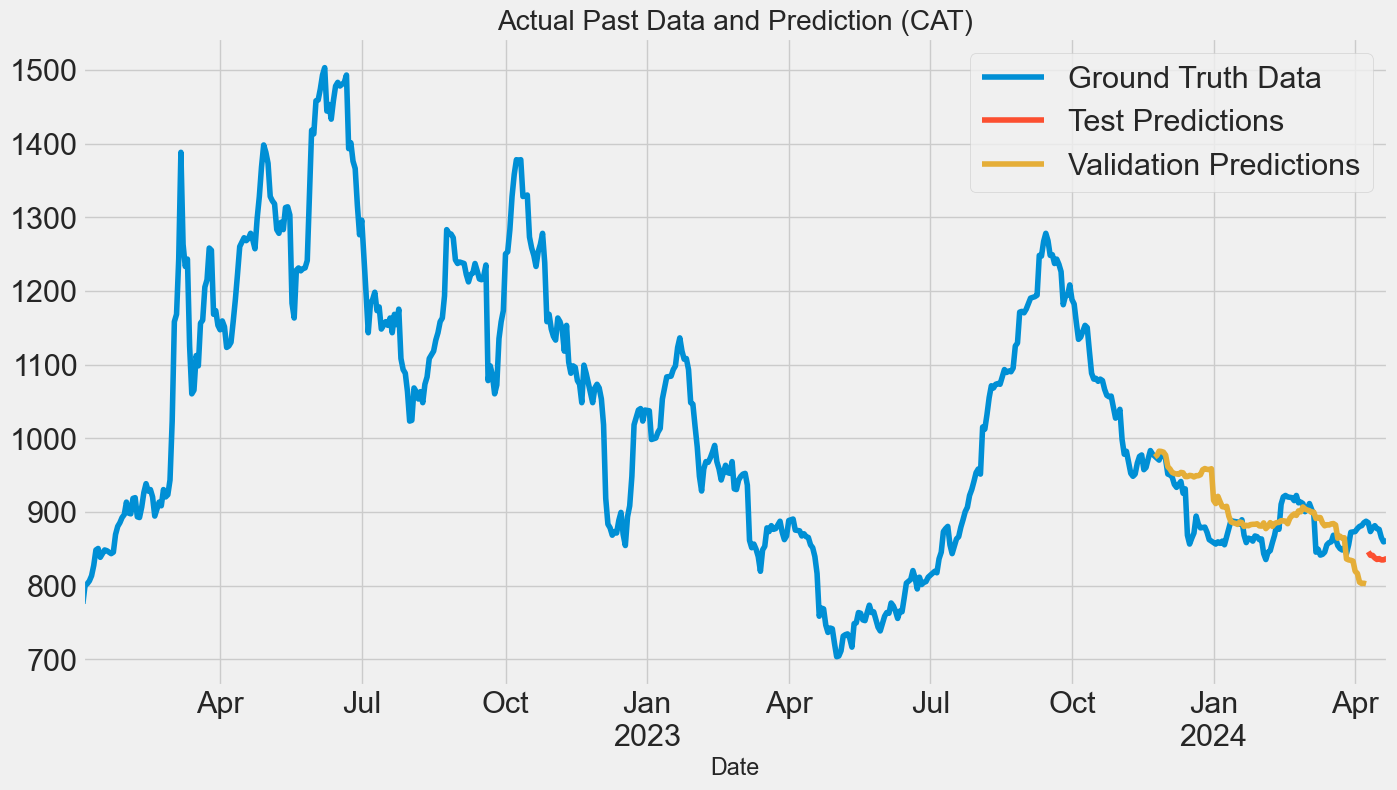

In [50]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_cat_ex3'].plot(ax=ax, style='-')
ts['prediction_cat_val_ex3'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (CAT)')
plt.show();

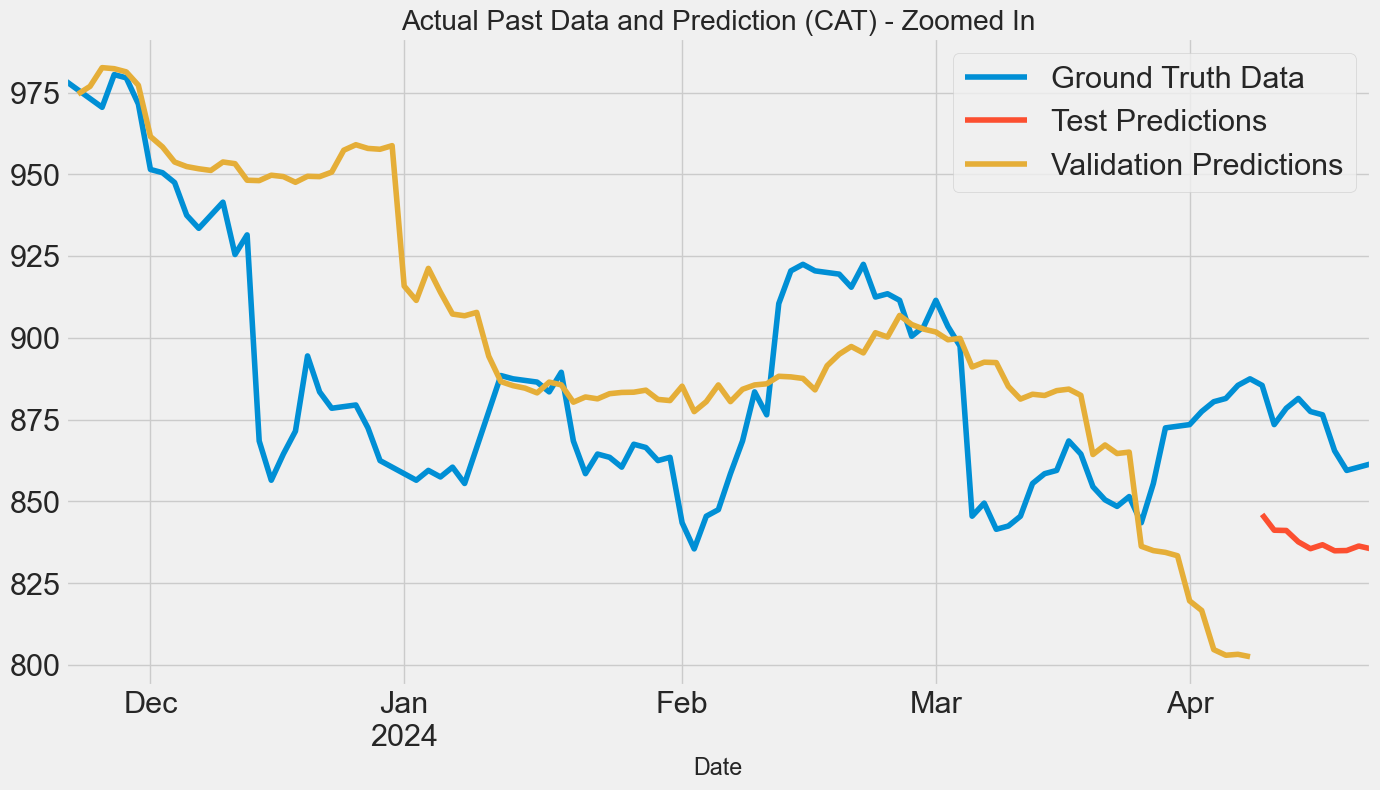

In [51]:
# 특정 날짜 범위를 지정하여 확대
start_date = '2023-11-22'
end_date = '2024-05-01'

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed['Marine Gasoil 9_Price'].plot(figsize=(15, 8))
ts_zoomed['prediction_cat_ex3'].plot(ax=ax, style='-')
ts_zoomed['prediction_cat_val_ex3'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (CAT) - Zoomed In')
plt.show()

#### MAE, RMSE, MAPE

In [52]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_cat_val_ex3', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_cat_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_val_ex3'])
score_rmse_cat_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_val_ex3']))
score_mape_cat_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_val_ex3'])

# 결과 출력
print(f'MAE Score on Validation set (CAT): {score_mae_cat_val:0.2f}')
print(f'RMSE Score on Validation set (CAT): {score_rmse_cat_val:0.2f}')
print(f'MAPE Score on Validation set (CAT): {score_mape_cat_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (CAT): 31.53
RMSE Score on Validation set (CAT): 41.35
MAPE Score on Validation set (CAT): 3.61%


In [53]:
ts_clean = ts.dropna(subset=['prediction_cat_ex3', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_cat = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_ex3'])
score_rmse_cat = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_ex3']))
score_mape_cat = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_cat_ex3'])

# 결과 출력
print(f'MAE Score on Test set (CAT): {score_mae_cat:0.2f}')
print(f'RMSE Score on Test set (CAT): {score_rmse_cat:0.2f}')
print(f'MAPE Score on Test set (CAT): {score_mape_cat:.2%}')  # 백분율 형식으로 출력

MAE Score on Test set (CAT): 33.97
RMSE Score on Test set (CAT): 34.70
MAPE Score on Test set (CAT): 3.89%


#### Shap

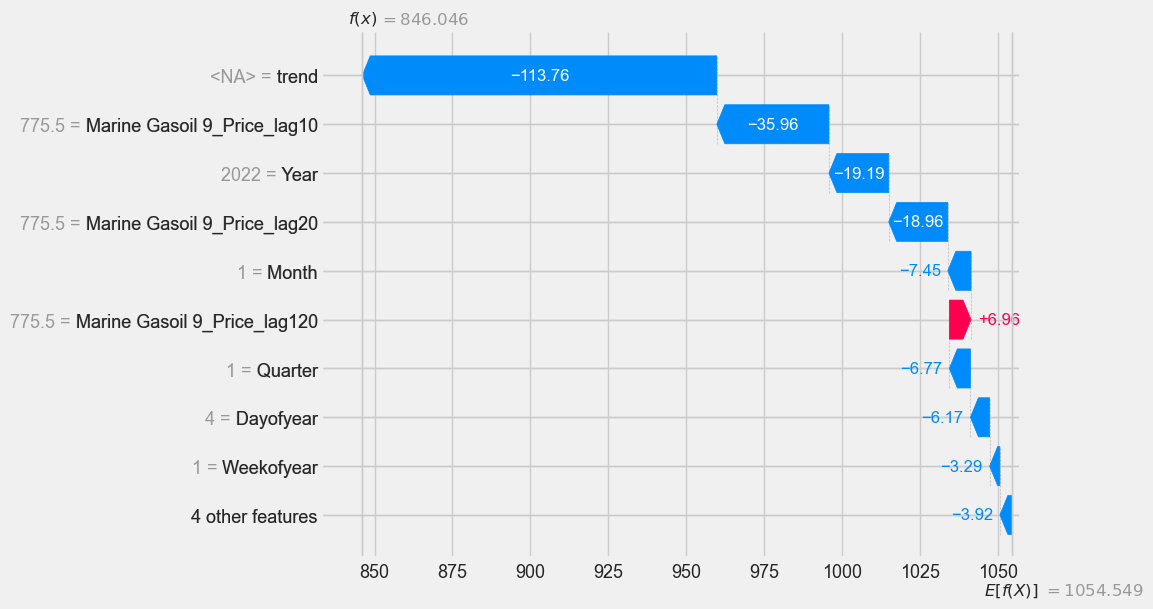

In [54]:
import shap

cat_explainer = shap.Explainer(cat_model)
shap_values_cat = cat_explainer.shap_values(X_test)

shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_cat[0],
                                     base_values=cat_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))